In [1]:
import pandas as pd
import numpy as np

artists_df = pd.read_csv("/Users/hoon/Desktop/4060J_DataScience_Project/artists.csv")

'''
# Load the preprocessed data 
1) parse & organize -> 2) feature extraction (pretrained ResNet50) -> 3) PCA to reduce dimentionality into 100
'''
image_metadata_reduced_df = pd.read_pickle('/Users/hoon/Desktop/image_metadata_reduced.pkl')


# Normalize artist names in both DataFrames (Albrecht Dürer)
import unicodedata

def normalize_name(name):
    return unicodedata.normalize('NFKD', name).encode('ascii', 'ignore').decode('utf-8').strip()

image_metadata_reduced_df['artist_name'] = image_metadata_reduced_df['artist_name'].apply(normalize_name)
artists_df['name'] = artists_df['name'].apply(normalize_name)

# Merge the genre/style information into the image metadata DataFrame
image_metadata_reduced_df = image_metadata_reduced_df.merge(
    artists_df[['name', 'genre']],  # Use the genre or style column from artists.csv
    left_on='artist_name',
    right_on='name',
    how='left'
)

# Drop the duplicate 'name' column
image_metadata_reduced_df.drop(columns=['name'], inplace=True)

# Ensure the 'genre' column exists and has no NaN values
if 'genre' in image_metadata_reduced_df.columns:
    image_metadata_reduced_df['genre'] = image_metadata_reduced_df['genre'].fillna("")
else:
    raise KeyError("The 'genre' column is missing from the DataFrame.")

# Create the 'genre_list' column
image_metadata_reduced_df['genre_list'] = image_metadata_reduced_df['genre'].apply(lambda x: x.split(","))

from sklearn.preprocessing import MultiLabelBinarizer

# One-hot encode the genres
mlb = MultiLabelBinarizer()
one_hot_genres = mlb.fit_transform(image_metadata_reduced_df['genre_list'])

# Add the one-hot encoded genres as columns
genre_columns = mlb.classes_
for idx, genre in enumerate(genre_columns):
    image_metadata_reduced_df[genre] = one_hot_genres[:, idx]

In [3]:
image_metadata_reduced_df

,file_name,artist_name,features,artist_label,genre,genre_list,Abstract Expressionism,Abstractionism,Art Nouveau,Baroque,...,Pop Art,Post-Impressionism,Primitivism,Proto Renaissance,Realism,Romanticism,Social Realism,Suprematism,Surrealism,Symbolism
0,Gustav_Klimt_113.jpg,Gustav Klimt,"[-104.051254, -30.065239, 40.834503, -27.93637...",19,"Symbolism,Art Nouveau","[Symbolism, Art Nouveau]",0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,Vincent_van_Gogh_388.jpg,Vincent van Gogh,"[-42.690506, 50.457077, -31.054712, 49.034294,...",48,Post-Impressionism,[Post-Impressionism],0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,Amedeo_Modigliani_24.jpg,Amedeo Modigliani,"[85.80638, 74.72588, 21.94299, -97.160614, 6.6...",2,Expressionism,[Expressionism],0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Edgar_Degas_455.jpg,Edgar Degas,"[110.57151, -27.310974, -106.109825, -26.60741...",10,Impressionism,[Impressionism],0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Edgar_Degas_333.jpg,Edgar Degas,"[128.26991, -22.02461, -65.37852, -10.970957, ...",10,Impressionism,[Impressionism],0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8350,Mikhail_Vrubel_116.jpg,Mikhail Vrubel,"[-112.82036, -11.718504, -2.0028427, -15.04778...",32,Symbolism,[Symbolism],0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8351,Joan_Miro_51.jpg,Joan Miro,"[-69.65716, 75.916565, -17.81109, -51.636993, ...",27,Surrealism,[Surrealism],0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8352,Frida_Kahlo_10.jpg,Frida Kahlo,"[53.062565, 15.8918295, -43.91319, -41.854576,...",16,"Primitivism,Surrealism","[Primitivism, Surrealism]",0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
8353,Vincent_van_Gogh_391.jpg,Vincent van Gogh,"[-88.60199, -56.594482, -37.02463, 22.391777, ...",48,Post-Impressionism,[Post-Impressionism],0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


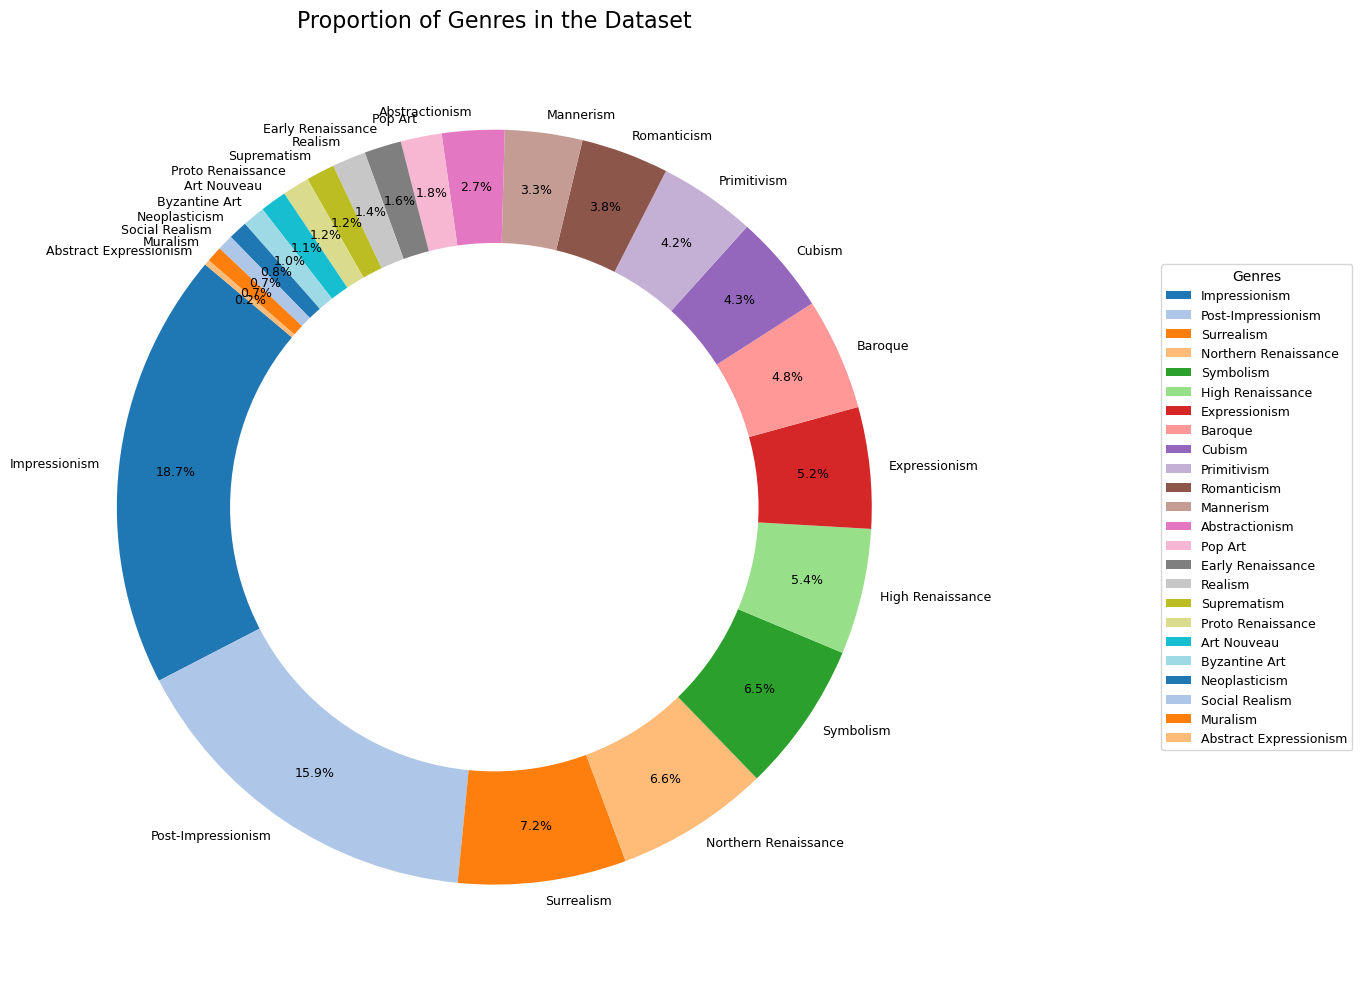

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Exploding the 'genre_list' column to count each genre individually
exploded_genres = image_metadata_reduced_df.explode('genre_list')

# Count the occurrences of each genre
genre_counts = exploded_genres['genre_list'].value_counts()

# Plot the pie chart
a = plt.figure(figsize=(14, 10))  # Increase figure size
wedges, texts, autotexts = plt.pie(
    genre_counts,
    labels=genre_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 9},  # Slightly larger label font size
    pctdistance=0.85,  # Place percentage labels closer to the center
    labeldistance=1.05,  # Add padding between the chart and labels
    colors=plt.cm.tab20.colors  # Use a colormap for better color variety
)

# Add a central circle for a donut effect
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
plt.gca().add_artist(centre_circle)

# Adjust the legend placement
plt.legend(
    genre_counts.index,
    title="Genres",
    loc="center left",
    bbox_to_anchor=(1.2, 0.5),  # Move legend further to the right
    fontsize=9  # Maintain a compact font size
)

# Set the title with a larger font size
plt.title('Proportion of Genres in the Dataset', fontsize=16)
plt.tight_layout()  # Ensure no overlap
plt.show()
a.savefig('/Users/hoon/Desktop/dataset_pie.jpg')

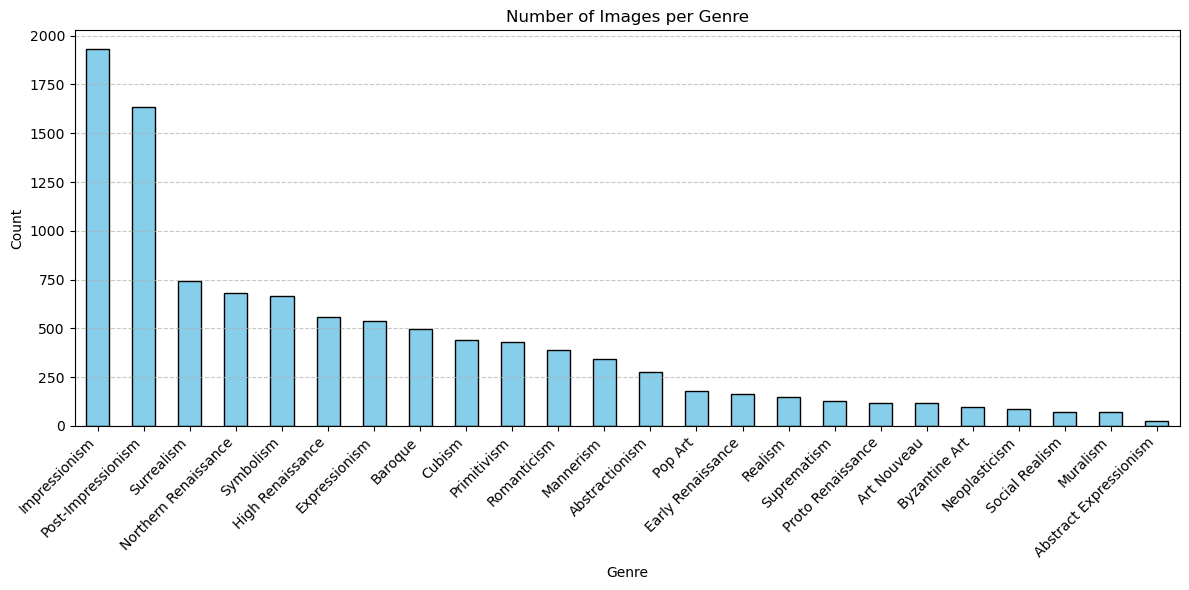

In [23]:
# Alternatively, a bar chart
b = plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Images per Genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
b.savefig('/Users/hoon/Desktop/dataset_histo.jpg')